## Compare portfolio theories
Here we use shares price history to compare various portfolio allocation theories.
Main idea is to compare different ways to get portfolio:
  * Markovitz optimal portfolio (max Sharpie portfolio)
  * Using Ledoit Wolf caovariance shrinkage
  * Minimal volatility portfolio
  * Market capitalization-weighted portfolio
  * Hierarchical Risk Parity

import necessary libs

In [2]:
import numpy as np
import tqdm
import pandas as pd
import datetime
import importlib

In [3]:
from pypoanal import portfolio_calculators
from pypoanal import dataloader
from pypoanal import backtester
from pypoanal import analyzer
from pypoanal import rebalancer

Use plotly backend for drawing charts

In [4]:
%matplotlib widget
pd.options.plotting.backend = "plotly"

## Load the data

Randomly select 50 tickers from ``info/shares_outstanding.csv`` file

In [5]:
tickers_list = np.array(dataloader.load_tickers(sample_size=50))
tickers_list

array(['BIP', 'AESE', 'FNB', 'MO', 'WSBC', 'MUA', 'NWS', 'INT', 'HTBI',
       'EARN', 'PKE', 'ALRM', 'HPQ', 'RVT', 'NFG', 'DCI', 'IBN', 'DTE',
       'OCC', 'HEI', 'LEN', 'MCY', 'RICK', 'SYF', 'SCHL', 'TEF', 'ABBV',
       'MUC', 'VIA', 'MBINP', 'FCF', 'BP', 'MAS', 'NNY', 'AXL', 'GCMG',
       'ABM', 'RQI', 'SRC', 'CUBA', 'CSWI', 'PNFP', 'RPM', 'RTLR', 'USLM',
       'LPG', 'SSB', 'LAZ', 'BKEP', 'SID'], dtype='<U5')

Load price and volume history for selected tickers

In [6]:
shares_history = dataloader.load_shares_history(tickers_list)

Loading price and volume: 100%|███████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.86it/s]


## Backtest Performance

Select various ways to create a portfolio from given shares

In [7]:
calculators = [portfolio_calculators.MCAPWeightsCalculator(),
               portfolio_calculators.LedoitWolfWeightsCalculator(),
               portfolio_calculators.MaxSharpeCalculator(),
               portfolio_calculators.HRPWeightsCalculator()]

We allocate portfolio according to one of the algorithms. Then, portfolio is rebalanced every **rebalance_period** days (e.g. annually).
As a result we get history of allocated portfolios, fees, and portfolio values is USD.
All of that is done in **compare_calculators_for_periodic_rebalance** method.
Here *backtesting* means testing the trategy back in time (using hitorical data). 

In [8]:
backtest_start_date = datetime.date(2006, 8, 8)
backtest_end_date = datetime.date(2021, 12, 12)
rebalance_period = datetime.timedelta(days=360)
rebalance_dates = backtester.compute_rebalance_dates(backtest_start_date,backtest_end_date,rebalance_period)
importlib.reload(backtester)

values_history_per_calc, fees_history_per_calc, portfolio_history_per_calc = backtester.compare_calculators_for_periodic_rebalance(calculators,
                                                                                                                  tickers_list,
                                                                                                                  10**4,
                                                                                                                  rebalance_dates,
                                                                                                                  shares_history=shares_history)

max_sharpe: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 23.13it/s]
/Users/renatyv/Documents/finance_python/pypoanal/backtester.py:60: UserWarning: could not allocate portfolio for the dates [datetime.date(2007, 8, 3), datetime.date(2008, 7, 28), datetime.date(2015, 6, 22), datetime.date(2018, 6, 6), datetime.date(2019, 6, 1)]
  warnings.warn(f'could not allocate portfolio for the dates {unallocated_dates}')
HRP: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.97it/s]


How did the value of the annually rebalanced market-cap weighted portfolio value changed over time:

In [9]:
values_history_per_calc['MCAP'].head()

2006-08-08    10000.000000
2007-08-03     9996.016683
2008-07-28     9482.597350
2009-07-23     8788.858107
2010-07-18     8878.986601
Name: MCAP, dtype: float64

How did the rebalance fees of the annually rebalanced market-cap weighted portfolio value changed over time:

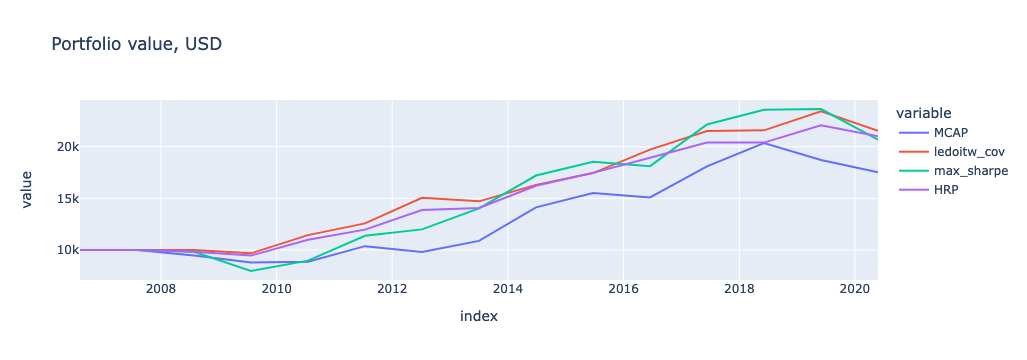

In [10]:
values_history_per_calc.plot(title=f'Portfolio value, USD')

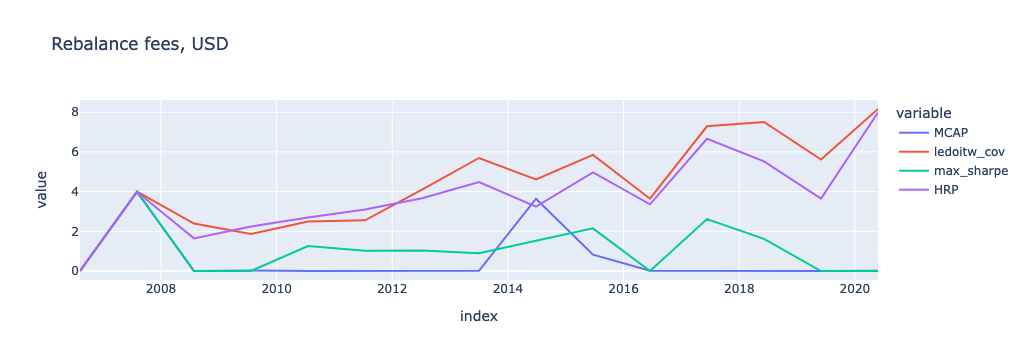

In [11]:
fees_history_per_calc.plot(title=f'Rebalance fees, USD')

##  Backtests varying start date
Now we can test how the date we start the backtest from affects the results

In [12]:
calculators = [portfolio_calculators.MCAPWeightsCalculator(),
               portfolio_calculators.LedoitWolfWeightsCalculator(),
               # portfolio_calculators.MaxSharpeCalculator(),
               portfolio_calculators.HRPWeightsCalculator()]

In [33]:
from random import randint
importlib.reload(backtester)
backtest_start_date = datetime.date(2010, 8, 8)
backtest_end_date = datetime.date(2022, 1, 15)
rebalance_period = datetime.timedelta(days=360)
num_starting_dates = 40
initial_cash = 10 ** 6
start_days_delta = list(sorted(set(randint(-4*365, 4*365) for k in range(num_starting_dates))))
start_dates = [backtest_start_date+datetime.timedelta(days=days) for days in start_days_delta]
# start_dates = [datetime.date(2009,5,10)]
stats: dict[pd.DataFrame] = dict()
for calculator in calculators:
    start_to_end_values_df = pd.DataFrame()
    calc_name = str(calculator)
    for start_date in tqdm.tqdm(start_dates,desc=calc_name,disable=False):
        rebalance_dates = backtester.compute_rebalance_dates(start_date,backtest_end_date,rebalance_period)
        portfolio_history, _ = backtester.reallocate_portfolio_periodically(calculator,
                                                                            rebalance_dates,
                                                                            initial_cash,
                                                                            fees_percent=0.04,
                                                                            shares_history=shares_history,
                                                                            progress_bar=False)
        values_history: list[np.float64] = backtester.portfolios_values_history(list(zip(rebalance_dates,portfolio_history)),
                                                                                shares_history.price_history)
        values_history_dataframe = pd.DataFrame({str(start_date):values_history},index=rebalance_dates)
        start_to_end_values_df = start_to_end_values_df.join(values_history_dataframe,how='outer')
    stats[calc_name] = start_to_end_values_df

HRP: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:02<00:00,  1.55s/it]


In [34]:
stats.keys()

dict_keys(['MCAP', 'ledoitw_cov', 'HRP'])

stats is a dict of dataframes. Column of each dataframe correspond to start date, rows correspond to next reallocation date.

In [35]:
stats['ledoitw_cov'].head()

2006-10-24  2006-10-31  2006-11-19  2006-12-19  2007-01-30  \
2006-10-24   1000000.0         NaN         NaN         NaN         NaN   
2006-10-31         NaN   1000000.0         NaN         NaN         NaN   
2006-11-19         NaN         NaN   1000000.0         NaN         NaN   
2006-12-19         NaN         NaN         NaN   1000000.0         NaN   
2007-01-30         NaN         NaN         NaN         NaN   1000000.0   

            2007-02-23  2007-07-06  2007-08-25  2007-09-25  2007-11-04  ...  \
2006-10-24         NaN         NaN         NaN         NaN         NaN  ...   
2006-10-31         NaN         NaN         NaN         NaN         NaN  ...   
2006-11-19         NaN         NaN         NaN         NaN         NaN  ...   
2006-12-19         NaN         NaN         NaN         NaN         NaN  ...   
2007-01-30         NaN         NaN         NaN         NaN         NaN  ...   

            2013-02-23  2013-03-29  2013-05-08  2013-06-03  2013-07-23  \
2006-10-24         NaN         NaN         NaN         NaN         NaN   
2006-10-31         NaN         NaN         NaN         NaN         NaN   
2006-11-19         NaN         NaN         NaN         NaN         NaN   
2006-12-19         NaN         NaN         NaN         NaN         NaN   
2007-01-30         NaN         NaN         NaN         NaN         NaN   

            2013-09-05  2013-09-19  2013-12-03  2013-12-05  2014-03-14  
2006-10-24         NaN         NaN         NaN         NaN         NaN  
2006-10-31         NaN         NaN         NaN         NaN         NaN  
2006-11-19         NaN         NaN         NaN         NaN         NaN  
2006-12-19         NaN         NaN         NaN         NaN         NaN  
2007-01-30         NaN         NaN         NaN         NaN         NaN  

[5 rows x 40 columns]

A-ha! Not trivial...

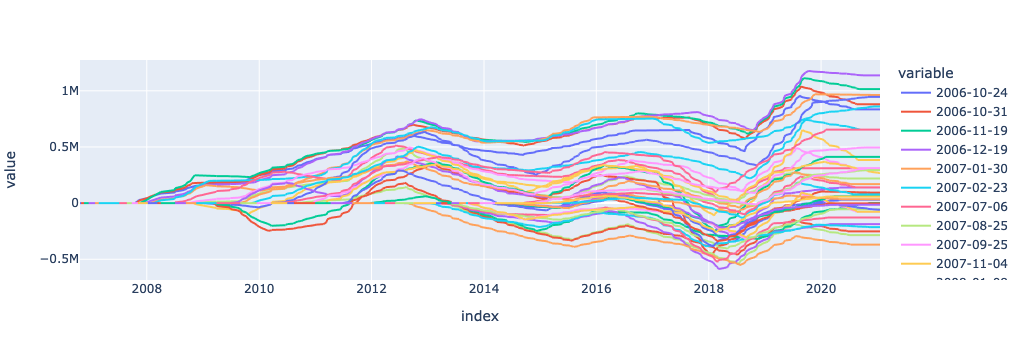

In [36]:
(stats['ledoitw_cov']-stats['MCAP']).interpolate().plot()

Comparing HRP results to marcet-cap weighted portfolios

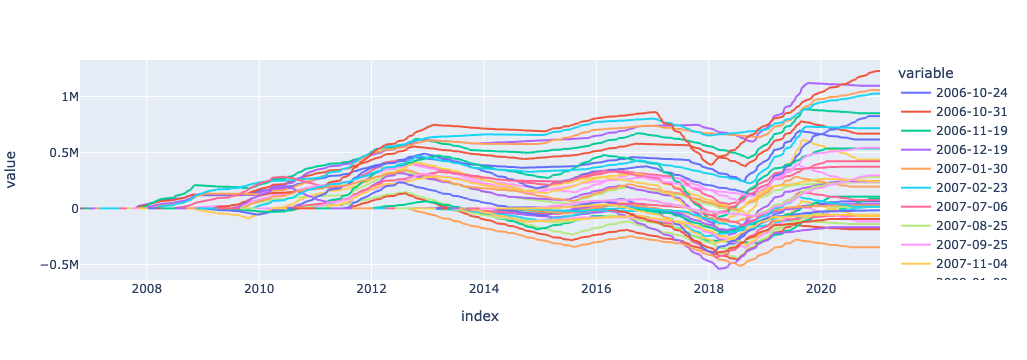

In [37]:
(stats['HRP']-stats['MCAP']).interpolate().plot()

Note, that portolios bought before the 2008 financial crysis performed much better, yielding significantly higher returns.

Consider distribution of portfolio values compared to MCAP. Start date is randomized.

In [48]:
import plotly.express as px
mcap_diff = pd.DataFrame()
mcap_diff['ledoitw_cov'] = (stats['ledoitw_cov']-stats['MCAP']).interpolate().iloc[-1]
mcap_diff['HRP'] = (stats['ledoitw_cov']-stats['HRP']).interpolate().iloc[-1]

In [66]:
mcap_diff.describe()

ledoitw_cov            HRP
count      38.000000      39.000000
mean   207350.968063   -2824.378371
std    360223.096306  103538.374388
min   -369333.185556 -230968.131777
25%    -44253.392677  -62018.968772
50%    115878.716448  -22223.208872
75%    366176.755282   53241.050924
max    963090.698527  233534.713523

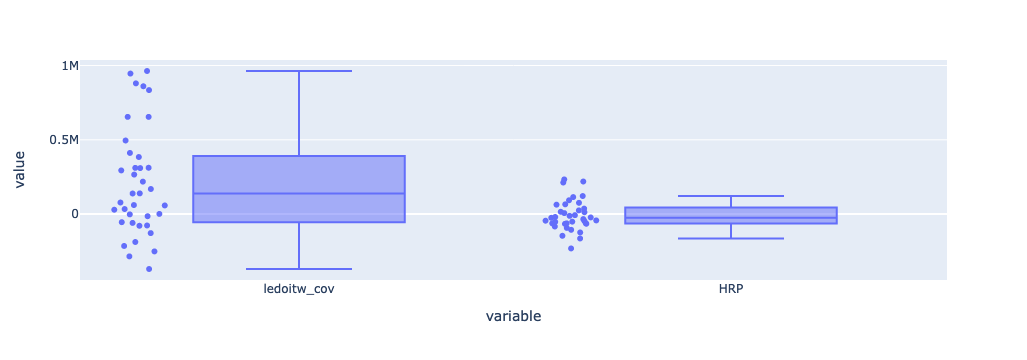

In [85]:
px.box(mcap_diff, y=['ledoitw_cov','HRP'], points='all')

Remove outliers

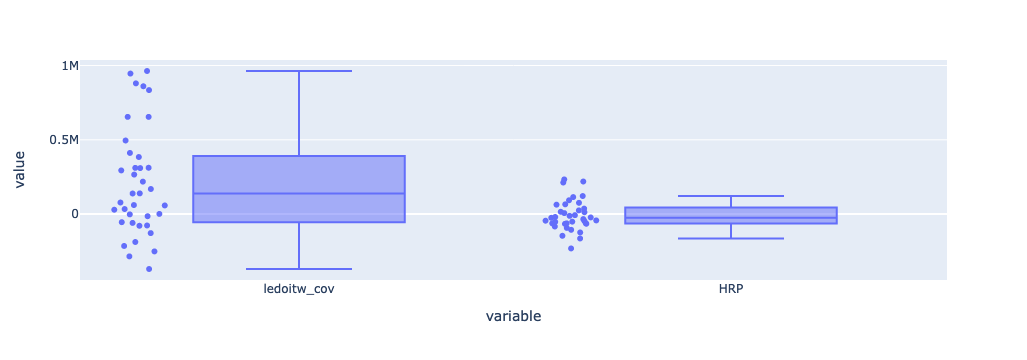

In [86]:
mcap_diff=mcap_diff[(mcap_diff>-1000_000) & (mcap_diff<1000_000)].dropna()
px.box(mcap_diff, y=['ledoitw_cov','HRP'], points='all')

Are they normally distributed? Let's apply Shapiro-Wilk test

In [87]:
import scipy.stats as st
st.shapiro(mcap_diff['ledoitw_cov']).pvalue, st.shapiro(mcap_diff['HRP']).pvalue

(0.02480020932853222, 0.12488548457622528)

95% Confidence interval for means

In [88]:
# returns confidence interval of mean
def conf_int_mean(a, conf=0.95):
    mu, sem, m = np.mean(a), st.sem(a), st.t.ppf((1+conf)/2., len(a)-1)
    return mu - m*sem, mu + m*sem

In [89]:
conf_int_mean(mcap_diff['ledoitw_cov']), conf_int_mean(mcap_diff['HRP'])

((88850.2914798181, 332031.6887105545),
 (-42668.48498553939, 25460.273027032184))

## Rolling performance

In [16]:
calculators = [portfolio_calculators.MCAPWeightsCalculator(),
               portfolio_calculators.LedoitWolfWeightsCalculator(),
               # portfolio_calculators.MaxSharpeCalculator(),
               portfolio_calculators.HRPWeightsCalculator()]

In [17]:
from pypoanal import analyzer
importlib.reload(analyzer)
importlib.reload(dataloader)

return_rates_df, sigmas_df = analyzer.rolling_performance(calculators,
                                                          tickers_list,
                                                          start_date=backtest_start_date,
                                                          end_date=backtest_end_date,
                                                          step_days=15,
                                                          sample_period=datetime.timedelta(days=365),
                                                          test_period=datetime.timedelta(days=90),
                                                          shares_history=shares_history)

MCAP


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [00:05<00:00, 42.87it/s]


ledoitw_cov


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [00:10<00:00, 23.38it/s]


HRP


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [00:43<00:00,  5.73it/s]


In [18]:
return_rates_df.head()

MCAP  ledoitw_cov       HRP
2010-08-08  0.022024     0.135009  0.109704
2010-08-23 -0.072305     0.042740  0.027967
2010-09-07 -0.041874     0.034934  0.027632
2010-09-22  0.091640     0.020632  0.050601
2010-10-07  0.124434     0.078602  0.097174

## Plot

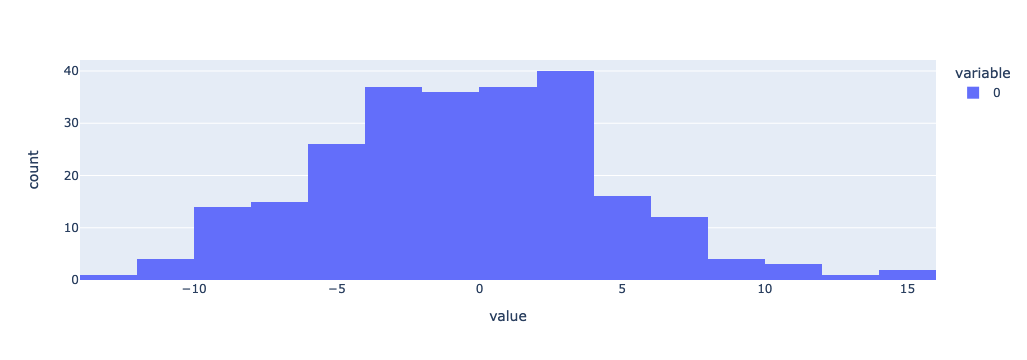

In [19]:
return_rates_diff_percent = (100*(return_rates_df['ledoitw_cov']-return_rates_df['MCAP']))
return_rates_diff_percent[(return_rates_diff_percent > -25) & (return_rates_diff_percent < 25)].hist()

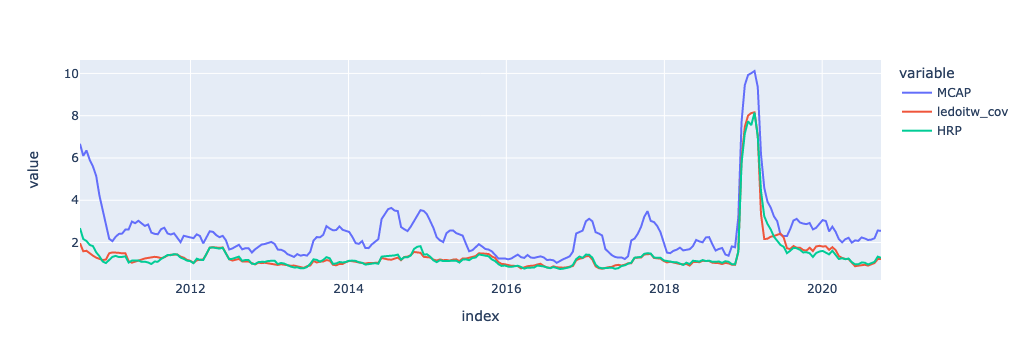

In [20]:
sigmas_df.plot()

In [1]:
sigmas_df[sigmas_df<6].boxplot()

NameError: name 'sigmas_df' is not defined